# Notebook 3: Modeling 

_For USD-599 Capstone Project by Hunter Blum, Kyle Esteban Dalope, and Nicholas Lee (Summer 2023)_

***

**Content Overview:**
1. Pipeline Creation
2. Data Splitting - Split by property_type_binary and train test split for each
3. Modeling - Two sets of models based on propery_type_binary that will be evaluated separately
4. Results

In [100]:
# Library Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor


import warnings
warnings.filterwarnings("ignore")

In [101]:
# Read in data from the previous notebook
clean_data = pd.read_csv("../../Data/model_ready.csv.gz", compression = "gzip")

In [102]:
clean_data.dtypes

host_listings_count                             float64
property_type                                    object
room_type                                        object
bathrooms                                       float64
bedrooms                                        float64
price                                           float64
minimum_nights                                    int64
maximum_nights                                    int64
minimum_minimum_nights                          float64
maximum_maximum_nights                          float64
has_availability                                 object
availability_30                                   int64
availability_365                                  int64
instant_bookable                                 object
calculated_host_listings_count                    int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               

In [103]:
# Change some features to the proper data types
# i.e. zipcode to categorical
clean_data["zipcode"] = clean_data["zipcode"].astype("category")

In [104]:
# Split the data by property type
house_df = clean_data.loc[clean_data["property_type_binary"] == "house"]
room_df = clean_data.loc[clean_data["property_type_binary"] == "room"]

# Drop the property types
house_df = house_df.drop(columns=['property_type_binary'])
room_df = room_df.drop(columns=['property_type_binary'])

## Pipeline Setup
-  Establish a unique pipeline for numerical and categorical columns separately
- Partition the dataset into training and test set (75:25 split)
- Fit and apply the transformer to the training set
- Applied the trained transformer to the test set
- Return the preprocessed, model-ready training and test sets

**Maybe we go back and keep _review_scores_average_ and in the pipeline, multiple the two features (avg. score and # of monthly reviews) together, to create a weighted score, and then drop it?**

I'm thinking if this app is for users, they will have this information will be readily accessible and they can enter it themselves. If we take this approach, we'll need to keep the original features so the vector exists for them in the model training data

In [105]:
# Separate numerical and categorical features
num_cols = house_df.select_dtypes(["int64", "float64"]).columns.tolist()
categorical_cols = house_df.select_dtypes("object").columns.tolist()

# Separate out the target
num_cols.remove('price')

In [106]:
# Set up separate pipelines for different datatypes

# Set transformer output as a pandas dataframe
set_config(transform_output="pandas")

# Numerical Pipeline
num_pipeline = Pipeline([
    ("standardscaler", StandardScaler())
])

# Categorical Pipeline
categorical_pipeline = Pipeline([
    # Handle_unknown = "ignore" to deal with one off values in categorical features
    ("encoder", OneHotEncoder(
        sparse_output = False, drop = "if_binary", handle_unknown = "ignore"
        )
    )
])

# Global Data Pipeline
data_transformer = ColumnTransformer(
    transformers = [
        ("numerical", num_pipeline, num_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ]
)

In [107]:
# A function to output preprocessed, model-ready data using the data_transformer
def preprocess_data(data_set, pipeline = data_transformer,
                    num_cols = num_cols, categorical_cols = categorical_cols):
    
    # Data partitioning 75:25 Train-Test Split
    training_data, testing_data = train_test_split(
        data_set, test_size = 0.25, random_state = 2023
        )
    
    # Separate target from df
    training_data_X = training_data.drop(columns = ['price'])
    train_data_y = training_data['price']

    testing_data_X = testing_data.drop(columns = ['price'])
    test_data_y = testing_data['price']

    # Fit and transform the training data partition
    trained_pipeline = pipeline.fit(training_data_X)
    train_data_X = trained_pipeline.transform(training_data_X)        

    # Transform the test data set based on the training data
    test_data_X = trained_pipeline.transform(testing_data_X)

    # Remove whitespace in col names
    train_data_X.columns = train_data_X.columns.str.replace(' ', '_')
    test_data_X.columns = test_data_X.columns.str.replace(' ', '_')

    # Remove slashes in col names
    train_data_X.columns = train_data_X.columns.str.replace('/', '_')
    test_data_X.columns = test_data_X.columns.str.replace('/', '_')

    return train_data_X, train_data_y, test_data_X, test_data_y, trained_pipeline

In [108]:
# Preprocess the house-type and room-type data sets
house_train_X, house_train_y, house_test_X, house_test_y, house_pipeline = preprocess_data(house_df)
room_train_X, room_train_y, room_test_X, room_test_y, room_pipeline = preprocess_data(room_df)

In [109]:
house_train_X

,numerical__host_listings_count,numerical__bathrooms,numerical__bedrooms,numerical__minimum_nights,numerical__maximum_nights,numerical__minimum_minimum_nights,numerical__maximum_maximum_nights,numerical__availability_30,numerical__availability_365,numerical__calculated_host_listings_count,...,categorical__property_type_Entire_villa,categorical__property_type_Farm_stay,categorical__property_type_Houseboat,categorical__property_type_Island,categorical__property_type_Tent,categorical__property_type_Tiny_home,categorical__property_type_Tipi,categorical__room_type_Entire_home_apt,categorical__has_availability_t,categorical__instant_bookable_t
4141,5.548004,-0.665540,-0.047026,-0.309028,1.366853,-0.288416,0.810553,-1.196731,-1.485365,0.213023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
14023,-0.228642,-0.665540,-0.838608,-0.309028,1.366853,-0.288416,0.810553,-1.196731,-0.652317,-0.469223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
14449,-0.232192,0.439711,0.744556,-0.368624,-1.060483,-0.348575,0.810553,-1.196731,-1.485365,-0.500234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
10903,0.016342,-0.665540,-0.047026,-0.368624,1.089820,-0.288416,0.810553,-0.050838,0.759897,1.546503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9276,-0.232192,0.439711,2.327721,-0.309028,1.366853,-0.288416,0.810553,-1.196731,-1.485365,-0.500234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6909,-0.232192,-0.665540,-0.838608,1.359671,1.366853,1.396023,0.810553,-1.196731,0.545685,-0.500234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2963,-0.207339,0.439711,-0.047026,-0.368624,-1.060483,-0.348575,0.810553,0.235635,-0.890331,-0.345178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
17873,-0.221541,-0.665540,-0.047026,-0.309028,-1.042894,-0.288416,-1.622047,1.572510,-0.779258,-0.407201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
6450,-0.225091,0.439711,-0.047026,-0.309028,-0.304139,-0.288416,0.810553,0.522108,1.196255,-0.500234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [ ]:
# Export trained pipeline
#pickle.dump(house_pipeline, open("../Deployment_Files/house_pipeline.sav", "wb"))
#pickle.dump(room_pipeline, open("../Deployment_Files/room_pipeline.sav", "wb"))

## Baseline Model - Multiple Linear Regression

### Room Model

We'll use statsmodels here instead of sklearn, since the diagnostic tools are a bit better.

Note Regarding the paper - For more concise coding, we applied transformations to the below code and evaluated, rather than repeating all code for each transformation. 

In [10]:
# Combine the dataframe back into one for the model
room_train = pd.concat([room_train_X, room_train_y], axis = 1)

# Get string of columns for formula
cols = list(room_train_X.columns)
cols_str = " + ".join(cols)
cols_str = str(cols_str)

# Fit the model
room_reg = smf.ols(formula= 'price ~' + cols_str, 
                            data = room_train).fit()

# Model summary
print(room_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     14.76
Date:                Sat, 29 Jul 2023   Prob (F-statistic):          8.50e-131
Time:                        14:40:08   Log-Likelihood:                -17640.
No. Observations:                2491   AIC:                         3.541e+04
Df Residuals:                    2425   BIC:                         3.580e+04
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### Residuals vs. Fitted Plot
Diagnostic plot code inspired from Jason Sadowski's R to Python Article : https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a
He does have a module in GitHub, but I couldn't get it to work: https://github.com/j-sadowski/FromRtoPython



In [11]:
def resid_v_fitted_plot(fitted_reg):
    # Metrics we need
    residuals = fitted_reg.resid
    fitted = fitted_reg.fittedvalues
    smooth = lowess(residuals, fitted)
    top5 = abs(residuals).sort_values(ascending = False)[:5]

    # Plot
    fig, ax = plt.subplots()
    ax.scatter(fitted, residuals, edgecolors= 'b', facecolors = 'none')
    ax.plot(smooth[:,0], smooth[:,1], color = 'r')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')
    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top5.index:
        ax.annotate(i,xy=(fitted[i],residuals[i]))

    plt.show()

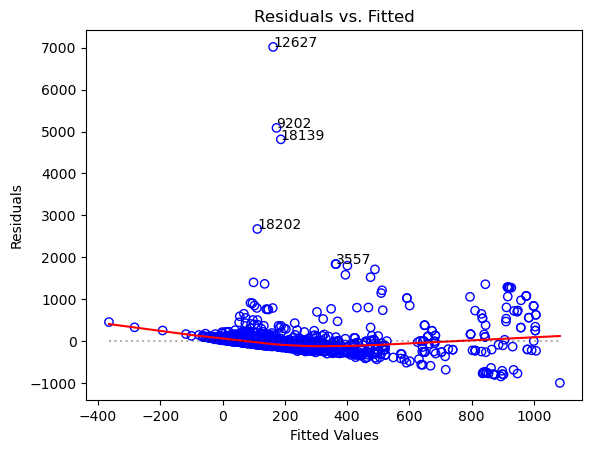

In [12]:
resid_v_fitted_plot(fitted_reg= room_reg)

### Q-Q Plot

In [13]:
def qq_plot(fitted_reg):
    # get the sorted residuals
    sorted_resid = pd.Series(fitted_reg.get_influence().resid_studentized_internal)
    sorted_resid.index = fitted_reg.resid.index
    sorted_resid = sorted_resid.sort_values(ascending=True)

    # make df from sorted resids
    df = pd.DataFrame(sorted_resid)
    df.columns = ['sorted_resid']
    df['theoretical_quants'] = stats.probplot(df['sorted_resid'], dist='norm', fit = False)[0]
    df = df.dropna()

    # Get the top five points
    ranks = abs(df['sorted_resid']).sort_values(ascending=False)
    top5 = ranks[:5]

    # Plot
    fig, ax = plt.subplots()
    x = df['theoretical_quants']
    y = df['sorted_resid']
    ax.scatter(x,y, edgecolor='b', facecolor = 'none')
    ax.set_title('Normal Q-Q')
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    ax.set_xlim([x.min() -1 , x.max() + 1])
    for val in top5.index:
        ax.annotate(val,xy=(df['theoretical_quants'].loc[val],df['sorted_resid'].loc[val]))
    plt.show()

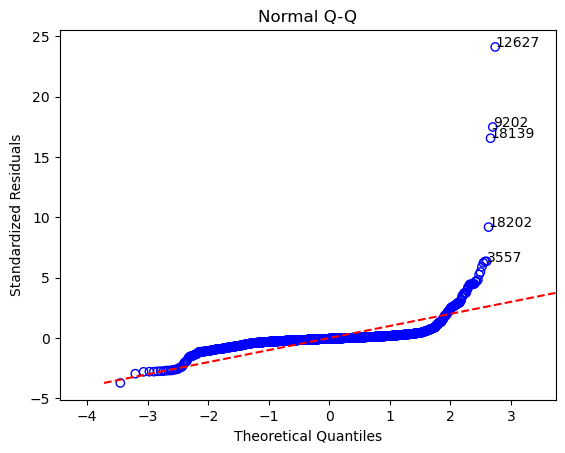

In [14]:
qq_plot(fitted_reg = room_reg)

### Scale-Location Plot

In [15]:
def scale_location_plot(fitted_reg):
    # Get sqrt of resids
    resids = fitted_reg.get_influence().resid_studentized_internal
    sqrt_resids = pd.Series(np.sqrt(np.abs(resids)))
    sqrt_resids.index = fitted_reg.resid.index
    smooth = lowess(sqrt_resids, fitted_reg.fittedvalues)
    
    top5 = abs(sqrt_resids).sort_values(ascending=False)[:5]

    # Plot
    fig, ax = plt.subplots()
    ax.scatter(fitted_reg.fittedvalues, sqrt_resids, edgecolors = 'b', facecolors = 'none')
    ax.plot(smooth[:,0],smooth[:,1],color = 'r')
    ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Scale-Location')
    ax.set_ylim(0,max(sqrt_resids)+0.1)
    for i in top5.index:
        ax.annotate(i,xy=(fitted_reg.fittedvalues[i],sqrt_resids[i]))
    plt.show()


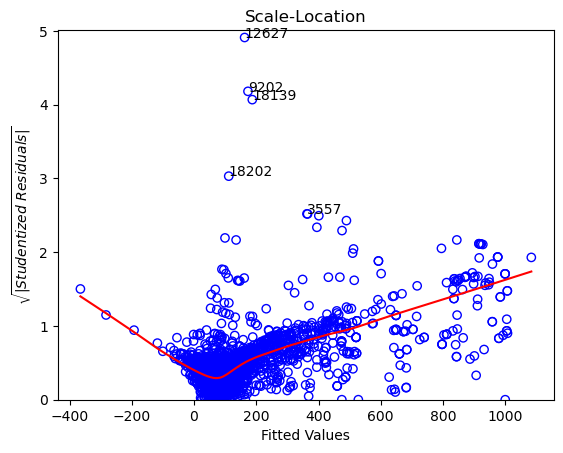

In [16]:
scale_location_plot(fitted_reg=room_reg)

### Cook's Distance

In [17]:
def cook_d_plot(fitted_reg):
    resids = pd.Series(fitted_reg.get_influence().resid_studentized_internal)
    resids.index = fitted_reg.resid.index
    df = pd.DataFrame(resids)
    df.columns = ['resids']
    df['leverage'] = fitted_reg.get_influence().hat_matrix_diag
    df = df.dropna()
    smoothed = lowess(df['resids'],df['leverage'])
    sorted_resids = abs(df['resids']).sort_values(ascending = False)
    top5 = sorted_resids[:5]

    fig, ax = plt.subplots()
    x = df['leverage']
    y = df['resids']
    xpos = max(x)+max(x)*0.01  
    ax.scatter(x, y, edgecolors = 'b', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Studentized Residuals')
    ax.set_xlabel('Leverage')
    ax.set_title('Residuals vs. Leverage')
    ax.set_ylim(min(y)-min(y)*0.15,30)
    ax.set_xlim(-0.01,max(x)+max(x)*0.05)
    plt.tight_layout()
    for val in top5.index:
        ax.annotate(val,xy=(x.loc[val],y.loc[val]))

    cooksx = np.linspace(min(x), xpos, 50)
    p = len(fitted_reg.params)
    poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
    poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
    negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
    negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

    ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
    ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
    ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
    ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
    ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
    ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
    ax.legend()
    plt.show()

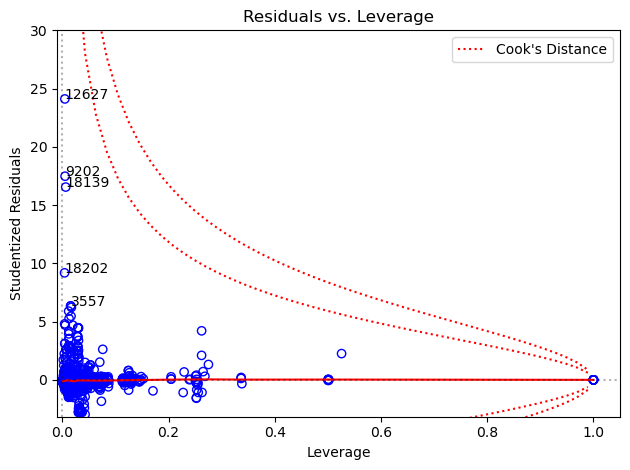

In [18]:
cook_d_plot(fitted_reg=room_reg)

### Entire Home Model

In [19]:
# Combine the dataframe back into one for the model
house_train = pd.concat([house_train_X, house_train_y], axis = 1)

# Get string of columns for formula
cols = list(house_train_X.columns)
cols_str = " + ".join(cols)
cols_str = str(cols_str)

# Fit the model
house_reg = smf.ols(formula= 'price ~' + cols_str, 
                            data = house_train).fit()

# Model summary
print(house_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     199.4
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:40:10   Log-Likelihood:                -80016.
No. Observations:               11379   AIC:                         1.601e+05
Df Residuals:                   11331   BIC:                         1.605e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

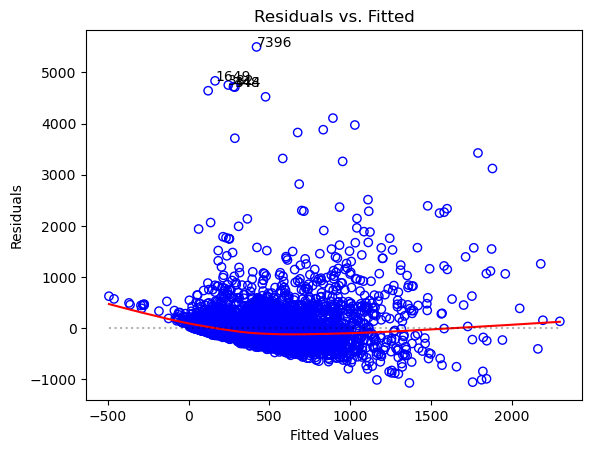

In [20]:
resid_v_fitted_plot(fitted_reg= house_reg)

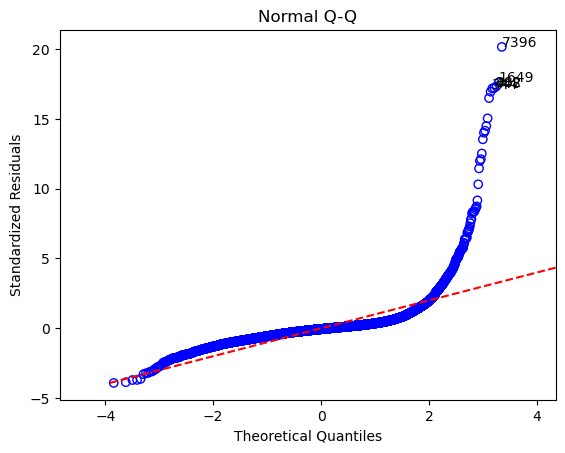

In [21]:
qq_plot(fitted_reg = house_reg)

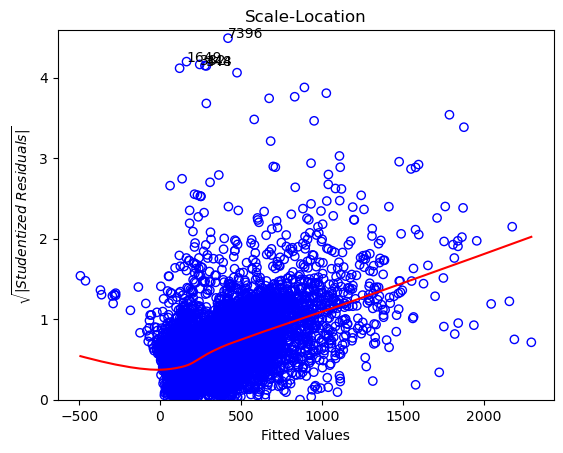

In [22]:
scale_location_plot(fitted_reg = house_reg)

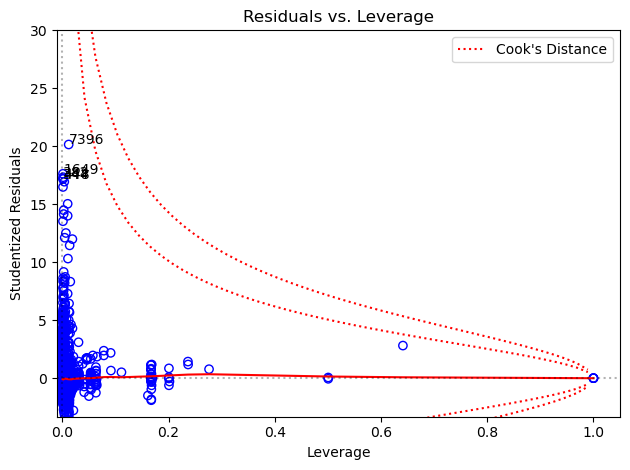

In [23]:
cook_d_plot(fitted_reg = house_reg)

In [24]:
# Pickle our models
pickle.dump(house_reg, open("Models/house_reg.sav", "wb"))
pickle.dump(room_reg, open("Models/room_reg.sav", "wb"))

## Lasso Regression
### Room Model

In [25]:
# Set up hyperparameter options
alpha = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10, 20, 25, 50, 100]

# Setup model pipeline so we can reference it in param_distributions
lasso_pipe = Pipeline(steps = [('lasso', Lasso())])

# Search
lasso_room_tuned = GridSearchCV(
    estimator= lasso_pipe,
    param_grid = {'lasso__alpha' : alpha},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(room_train_X, room_train_y)

# Return the best model parameters
lasso_room_tuned.best_params_

{'lasso__alpha': 0.5}

### House Model

In [26]:
# Search
lasso_house_tuned = GridSearchCV(
    estimator= lasso_pipe,
    param_grid = {'lasso__alpha' : alpha},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(house_train_X, house_train_y)

# Return the best model parameters
lasso_house_tuned.best_params_

{'lasso__alpha': 0.1}

## Ridge Regression
### Room Model

In [27]:
# Set up hyperparameter options
alpha = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10, 20, 25, 50, 100]

# Setup model pipeline so we can reference it in param_distributions
ridge_pipe = Pipeline(steps = [('ridge', Ridge())])

# Search
ridge_room_tuned = GridSearchCV(
    estimator= ridge_pipe,
    param_grid = {'ridge__alpha' : alpha},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(room_train_X, room_train_y)

# Return the best model parameters
ridge_room_tuned.best_params_

{'ridge__alpha': 5}

### House Model

In [28]:
# Search
ridge_house_tuned = GridSearchCV(
    estimator= ridge_pipe,
    param_grid = {'ridge__alpha' : alpha},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(house_train_X, house_train_y)

# Return the best model parameters
ridge_house_tuned.best_params_

{'ridge__alpha': 5}

## Elastic Net Model
### Room Model

In [29]:
# Set up hyperparameter options
alpha = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10, 20, 25, 50, 100]
l1_ratio = np.arange(0, 1, 0.1)

# Setup model pipeline so we can reference it in param_distributions
enet_pipe = Pipeline(steps = [('enet', ElasticNet())])

# Search
enet_room_tuned = GridSearchCV(
    estimator= enet_pipe,
    param_grid = {'enet__alpha' : alpha,
                  'enet__l1_ratio' : l1_ratio},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(room_train_X, room_train_y)

# Return the best model parameters
enet_room_tuned.best_params_

{'enet__alpha': 0.01, 'enet__l1_ratio': 0.9}

### House Model

In [30]:
# Search
enet_house_tuned = GridSearchCV(
    estimator= enet_pipe,
    param_grid = {'enet__alpha' : alpha,
                  'enet__l1_ratio' : l1_ratio},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(house_train_X, house_train_y)

# Return the best model parameters
enet_house_tuned.best_params_

{'enet__alpha': 0.001, 'enet__l1_ratio': 0.2}

In [31]:
# Pickle all the regularized models
pickle.dump(lasso_room_tuned, open("Models/lasso_room_tuned.sav", "wb"))
pickle.dump(lasso_house_tuned, open("Models/lasso_house_tuned.sav", "wb"))

pickle.dump(ridge_room_tuned, open("Models/ridge_room_tuned.sav", "wb"))
pickle.dump(ridge_house_tuned, open("Models/ridge_house_tuned.sav", "wb"))

pickle.dump(enet_room_tuned, open("Models/enet_room_tuned.sav", "wb"))
pickle.dump(enet_house_tuned, open("Models/enet_house_tuned.sav", "wb"))

## Random Forest

In [32]:
# Combine the dataframe back into one for the model
room_train = pd.concat([room_train_X, room_train_y], axis = 1)

# Import Random Forest Regressor Model
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [200, 500, 1000]
# Maximum number of levels in tree
max_depth = [2, 5, 10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Dictionary for GridSearch
param_grid_rf = {"n_estimators": n_estimators,
               "max_depth": max_depth,
               "min_samples_split": min_samples_split,
               "min_samples_leaf": min_samples_leaf}

# Create a Random Forest Model
rf = RandomForestRegressor(random_state = 2023)

# Set up Model GridSearch
rf_grid_search = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid_rf,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1
    )

### Random Forest - Room Model

In [33]:
# Fit to room data
# Fit grid-search to training data
rf_room_tuned = rf_grid_search.fit(room_train_X, room_train_y)

# Best random forest parameters for room data
rf_room_tuned.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

#### Random Forest - Room Model - Feature Importance

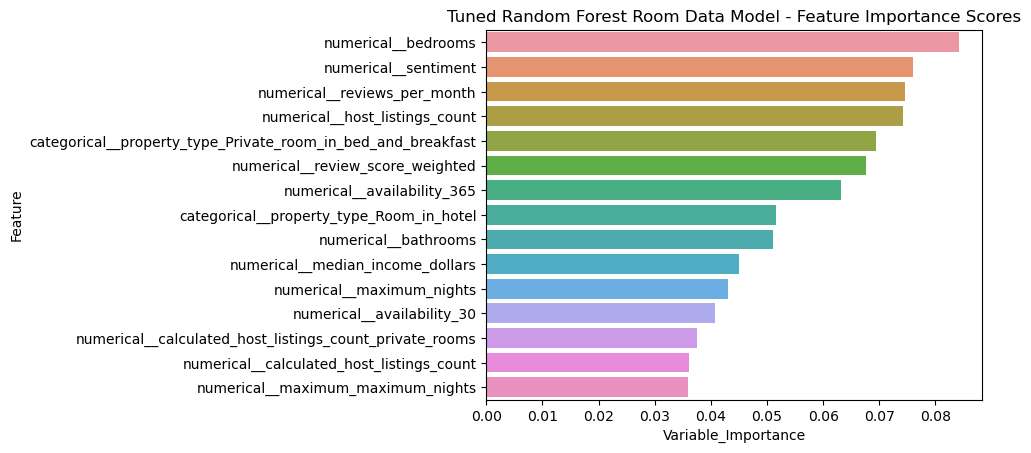

In [34]:
# From GridSearchCV get the features and importance scores of the best model
rf_room_feats = rf_room_tuned.best_estimator_.feature_names_in_.tolist()
feat_importance = rf_room_tuned.best_estimator_.feature_importances_.tolist()

# Convert the features and importance scores to a dataframe
# Organize from largest to smallest importance scores
rf_room_feat_import_df = pd.DataFrame(
    {"Feature" : rf_room_feats,
     "Variable_Importance" : feat_importance}
).sort_values(by = "Variable_Importance", ascending = False)

# Plot the top 15 features
sns.barplot(
    data = rf_room_feat_import_df.head(15),
    x = "Variable_Importance",
    y = "Feature"
)

plt.title("Tuned Random Forest Room Data Model - Feature Importance Scores")
plt.show()

### Random Forest - House Model

In [35]:
# Reset grid search
house_grid_search = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid_rf,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1
    )

# Fit to house data
# Fit grid-search to training data
rf_house_tuned = house_grid_search.fit(house_train_X, house_train_y)

# Best random forest parameters for house data
rf_house_tuned.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

#### Random Forest - House Model - Feature Importance

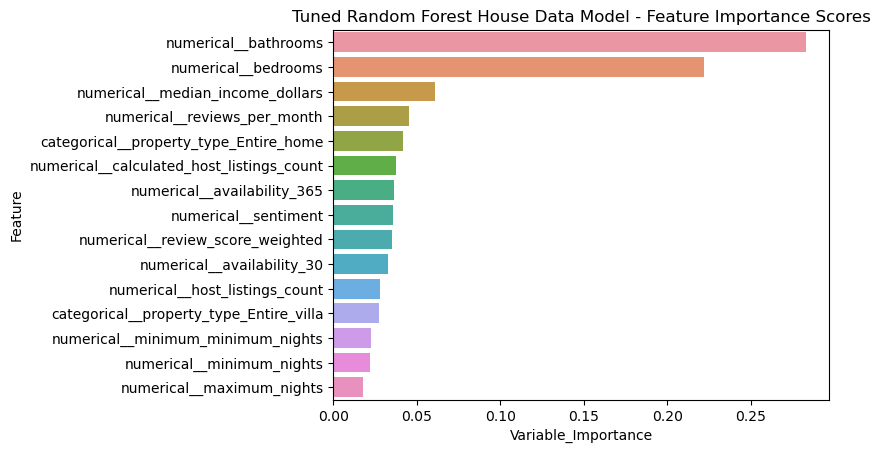

In [36]:
# From GridSearchCV get the features and importance scores of the best model
rf_house_feats = rf_house_tuned.best_estimator_.feature_names_in_.tolist()
feat_importance = rf_house_tuned.best_estimator_.feature_importances_.tolist()

# Convert the features and importance scores to a dataframe
# Organize from largest to smallest importance scores
rf_house_feat_import_df = pd.DataFrame(
    {"Feature" : rf_house_feats,
     "Variable_Importance" : feat_importance}
).sort_values(by = "Variable_Importance", ascending = False)

# Plot the top 15 features
sns.barplot(
    data = rf_house_feat_import_df.head(15),
    x = "Variable_Importance",
    y = "Feature"
)

plt.title("Tuned Random Forest House Data Model - Feature Importance Scores")
plt.show()

Pickle the random forest models to prevent the need for re-training.

In [37]:
# Pickle tuned models for future use
pickle.dump(rf_room_tuned, open("Models/rf_room_tuned.sav", "wb"))
pickle.dump(rf_house_tuned, open("Models/rf_house_tuned.sav", "wb"))

## Support Vector Regression

In [38]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.5, 1.0]
}

# Set up Model GridSearch
svr_search = GridSearchCV(
    estimator = SVR(), 
    param_grid = param_grid,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1
    )

### Room Data

In [39]:
# Fit to room data
# Fit grid-search to training data
svr_room_tuned = svr_search.fit(room_train_X, room_train_y)
svr_room_tuned.best_params_

{'C': 1000, 'epsilon': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

### Home Data

In [40]:
# Set up Model GridSearch
svr_search = GridSearchCV(
    estimator = SVR(), 
    param_grid = param_grid,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1
    )

svr_house_tuned = svr_search.fit(house_train_X, house_train_y)
svr_house_tuned.best_params_

{'C': 1000, 'epsilon': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

In [41]:
# Pickle
pickle.dump(svr_house_tuned, open("Models/svr_house_tuned.sav", "wb"))
pickle.dump(svr_room_tuned, open("Models/svr_room_tuned.sav", "wb"))

## Gradient Boosting Regression

In [13]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'subsample': [0.5, 0.7, 0.9, 1.0]
}

# Set up Model GridSearch
gb_search = RandomizedSearchCV(
    estimator = GradientBoostingRegressor(random_state=2023), 
    param_distributions = param_grid,
    n_iter= 200,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1,
    random_state= 2023
    )

### Room Model

In [14]:
gb_room_tuned = gb_search.fit(room_train_X, room_train_y)
gb_room_tuned.best_params_

{'subsample': 0.9,
 'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'learning_rate': 0.01}

### House Model


In [15]:
# Set up Model GridSearch
gb_search = RandomizedSearchCV(
    estimator = GradientBoostingRegressor(random_state=2023), 
    param_distributions = param_grid,
    n_iter= 100,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1,
    random_state= 2023
    )

gb_house_tuned = gb_search.fit(house_train_X, house_train_y)
gb_house_tuned.best_params_

{'subsample': 0.9,
 'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_depth': 5,
 'learning_rate': 0.1}

In [16]:
# Pickle
pickle.dump(gb_house_tuned, open("Models/gb_house_tuned.sav", "wb"))
pickle.dump(gb_room_tuned, open("Models/gb_room_tuned.sav", "wb"))

## Neural Network

In [14]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,), (100, 50), (200, 100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate_init': [0.001, 0.01, 0.1, 0.5],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5]
}


# Set up Model GridSearch
nn_search = GridSearchCV(
    estimator = MLPRegressor(random_state=2023), 
    param_grid = param_grid,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1
    )

### Room Model

In [15]:
nn_room_tuned = nn_search.fit(room_train_X, room_train_y)
nn_room_tuned.best_params_

{'activation': 'relu',
 'alpha': 0.5,
 'hidden_layer_sizes': (100, 50),
 'learning_rate_init': 0.001}

### House Model

In [16]:
# Set up Model GridSearch
nn_search = RandomizedSearchCV(
    estimator = MLPRegressor(random_state=2023), 
    param_distributions = param_grid,
    n_iter= 25,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1,
    random_state= 2023
    )

nn_house_tuned = nn_search.fit(house_train_X, house_train_y)
nn_house_tuned.best_params_

{'learning_rate_init': 0.01,
 'hidden_layer_sizes': (50,),
 'alpha': 0.5,
 'activation': 'relu'}

In [17]:
# Pickle
pickle.dump(nn_house_tuned, open("Models/nn_house_tuned.sav", "wb"))
pickle.dump(nn_room_tuned, open("Models/nn_room_tuned.sav", "wb"))

## KNN

In [10]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29],        
    'weights': ['uniform', 'distance'],    
    'p': [1, 2]
    }


# Set up Model GridSearch
knn_search = GridSearchCV(
    estimator = KNeighborsRegressor(), 
    param_grid = param_grid,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1
    )

### Room

In [11]:
knn_room_tuned = knn_search.fit(room_train_X, room_train_y)
knn_room_tuned.best_params_

{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}

### House

In [12]:
# Set up Model GridSearch
knn_search = GridSearchCV(
    estimator = KNeighborsRegressor(), 
    param_grid = param_grid,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1
    )

knn_house_tuned = knn_search.fit(house_train_X, house_train_y)
knn_house_tuned.best_params_

{'n_neighbors': 13, 'p': 1, 'weights': 'distance'}

In [13]:
# Pickle
pickle.dump(knn_house_tuned, open("Models/knn_house_tuned.sav", "wb"))
pickle.dump(knn_room_tuned, open("Models/knn_room_tuned.sav", "wb"))

## Results
Load and predict our pickled models

In [14]:
# Load our models
house_reg_load = pickle.load(open('Models/house_reg.sav', 'rb'))
room_reg_load = pickle.load(open('Models/room_reg.sav', 'rb'))

house_lasso_load = pickle.load(open('Models/lasso_house_tuned.sav', 'rb'))
room_lasso_load = pickle.load(open('Models/lasso_room_tuned.sav', 'rb'))

house_ridge_load = pickle.load(open('Models/ridge_house_tuned.sav', 'rb'))
room_ridge_load = pickle.load(open('Models/ridge_room_tuned.sav', 'rb'))

house_enet_load = pickle.load(open('Models/enet_house_tuned.sav', 'rb'))
room_enet_load = pickle.load(open('Models/enet_room_tuned.sav', 'rb'))

house_rf_load = pickle.load(open('Models/rf_house_tuned.sav', 'rb'))
room_rf_load = pickle.load(open('Models/rf_room_tuned.sav', 'rb'))

house_svr_load = pickle.load(open('Models/svr_house_tuned.sav', 'rb'))
room_svr_load = pickle.load(open('Models/svr_room_tuned.sav', 'rb'))

house_gb_load = pickle.load(open('Models/gb_house_tuned.sav', 'rb'))
room_gb_load = pickle.load(open('Models/gb_room_tuned.sav', 'rb'))

house_nn_load = pickle.load(open('Models/nn_house_tuned.sav', 'rb'))
room_nn_load = pickle.load(open('Models/nn_room_tuned.sav', 'rb'))

house_knn_load = pickle.load(open('Models/knn_house_tuned.sav', 'rb'))
room_knn_load = pickle.load(open('Models/knn_room_tuned.sav', 'rb'))

# Predict the models
room_reg_pred = room_reg_load.predict(room_test_X)
lasso_room_pred = room_lasso_load.predict(room_test_X)
ridge_room_pred = room_ridge_load.predict(room_test_X)
enet_room_pred = room_enet_load.predict(room_test_X)
rf_room_pred = room_rf_load.predict(room_test_X)
svr_room_pred = room_svr_load.predict(room_test_X)
gb_room_pred = room_gb_load.predict(room_test_X)
nn_room_pred = room_nn_load.predict(room_test_X)
knn_room_pred = room_knn_load.predict(room_test_X)


house_reg_pred = house_reg_load.predict(house_test_X)
lasso_house_pred = house_lasso_load.predict(house_test_X)
ridge_house_pred = house_ridge_load.predict(house_test_X)
enet_house_pred = house_enet_load.predict(house_test_X)
rf_house_pred = house_rf_load.predict(house_test_X)
svr_house_pred = house_svr_load.predict(house_test_X)
gb_house_pred = house_gb_load.predict(house_test_X)
nn_house_pred = house_nn_load.predict(house_test_X)
knn_house_pred = house_knn_load.predict(house_test_X)


Make function to calculate adjusted R2

In [15]:
def adj_r2(y_test, y_pred, X_df):
    # Calculate r2
    r2 = r2_score(y_test, y_pred)

    # Get number of observations and features
    n = len(y_test)
    feats = X_df.shape[1]

    # Calculate Adjusted R2
    adjusted_r2 = 1 - (1 - r2) * (n-1) / (n-feats-1)

    return(adjusted_r2)

### Room Results

In [16]:
adj_r2_scores = []
rmse_scores = []
mae_scores = []

# Set up lists for our loop and df
preds = [room_reg_pred, lasso_room_pred, ridge_room_pred, enet_room_pred, rf_room_pred ,svr_room_pred, gb_room_pred, 
nn_room_pred, knn_room_pred]

model_names = ['Lin Reg', 'Lasso', 'Ridge', 'ENet', 'Random Forest', 'SVR','Gradient Boost', 'Neural Net', 'KNN']
room = ['Room']*len(model_names)

for pred in preds:
    # Get our metrics
    adj_r2_score = adj_r2(room_test_y, pred, room_test_X)
    rmse = np.sqrt(mean_squared_error(room_test_y, pred))
    mae = mean_absolute_error(room_test_y, pred)

    # Append each 
    adj_r2_scores.append(adj_r2_score)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

# Make df from lists
room_res = pd.DataFrame(list(zip(model_names, room, adj_r2_scores, rmse_scores, mae_scores)),
                                columns = ['Model', 'house_room','adj_r2', 'rmse', 'mae'])

room_res

,Model,house_room,adj_r2,rmse,mae
0,Lin Reg,Room,0.273702,262.523363,101.872823
1,Lasso,Room,0.272232,262.788937,101.651620
2,Ridge,Room,0.269024,263.367473,102.423881
3,ENet,Room,0.271419,262.935529,102.167889
4,Random Forest,Room,0.520757,213.249576,72.636090
5,SVR,Room,0.379579,242.635199,61.855131
6,Gradient Boost,Room,0.529013,211.404913,68.162760
7,Neural Net,Room,0.385086,241.555837,84.101429
8,KNN,Room,0.455374,227.331621,70.166645


### Home Results

In [17]:
adj_r2_scores = []
rmse_scores = []
mae_scores = []

# Set up lists for our loop and df
preds = [house_reg_pred, lasso_house_pred, ridge_house_pred, enet_house_pred, rf_house_pred, svr_house_pred,
         gb_house_pred, nn_house_pred, knn_house_pred]

model_names = ['Lin Reg', 'Lasso', 'Ridge', 'ENet', 'Random Forest','SVR','Gradient Boost', 'Nerual Net', 'KNN']
house = ['House']*len(model_names)

for pred in preds:
    # Get our metrics
    adj_r2_score = adj_r2(house_test_y, pred, house_test_X)
    rmse = np.sqrt(mean_squared_error(house_test_y, pred))
    mae = mean_absolute_error(house_test_y, pred)

    # Append each 
    adj_r2_scores.append(adj_r2_score)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

# Make df from lists
home_res = pd.DataFrame(list(zip(model_names, house, adj_r2_scores, rmse_scores, mae_scores)),
                                columns = ['Model', 'house_room','adj_r2', 'rmse', 'mae'])

home_res

,Model,house_room,adj_r2,rmse,mae
0,Lin Reg,House,0.419934,302.676885,140.687605
1,Lasso,House,0.420593,302.504711,140.413040
2,Ridge,House,0.420593,302.504836,140.539155
3,ENet,House,0.420614,302.499274,140.534734
4,Random Forest,House,0.472371,288.672133,122.094143
5,SVR,House,0.426756,300.891700,114.531438
6,Gradient Boost,House,0.500008,281.010073,118.544366
7,Nerual Net,House,0.487061,284.625189,129.863178
8,KNN,House,0.489010,284.083841,117.808010


## Feature Importance for Gradient Boosting
### Room

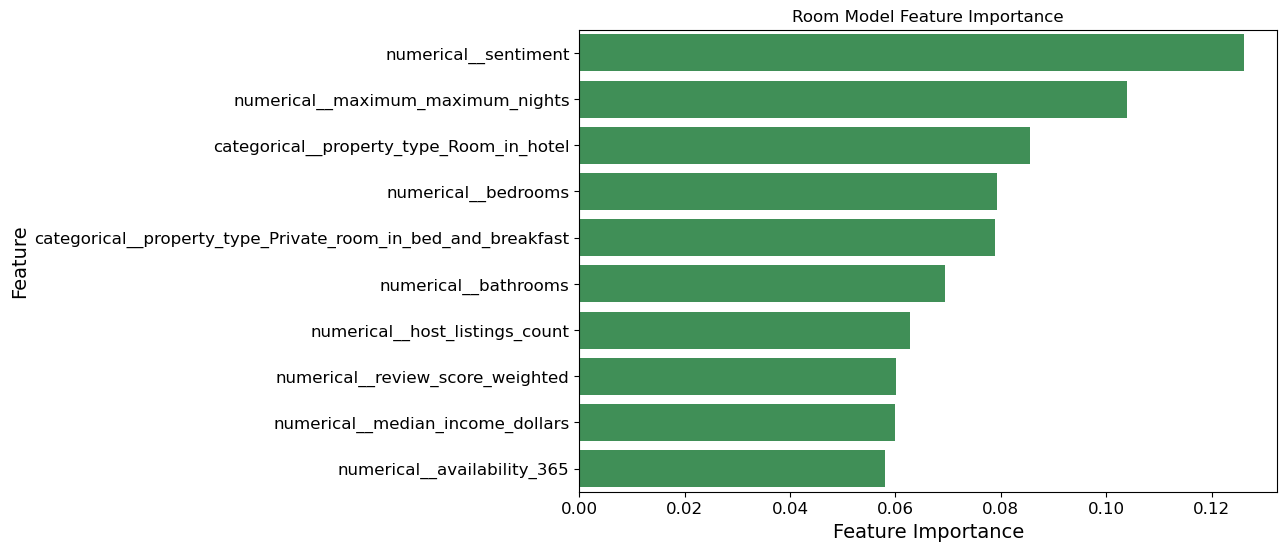

In [18]:
room_gb_load = pickle.load(open('Models/gb_room_tuned.sav', 'rb'))# From GridSearchCV get the features and importance scores of the best model
feats = room_gb_load.best_estimator_.feature_names_in_.tolist()
importance = room_gb_load.best_estimator_.feature_importances_.tolist()

# Convert the features and importance scores to a dataframe
# Organize from largest to smallest importance scores
importance_df = pd.DataFrame(
    {"Feature" : feats,
     "Variable_Importance" : importance}
).sort_values(by = "Variable_Importance", ascending = False)

paper_green = '#339c52'
plt.figure(figsize=(9,6))

# Plot the top 15 features
sns.barplot(
    data = importance_df.head(10),
    x = "Variable_Importance",
    y = "Feature",
    color= paper_green
)

plt.xlabel("Feature Importance", fontsize = 14)
plt.xticks(fontsize = 12)

plt.ylabel("Feature",fontsize = 14)
plt.yticks(fontsize = 12)
plt.title("Room Model Feature Importance")

plt.show()

### House

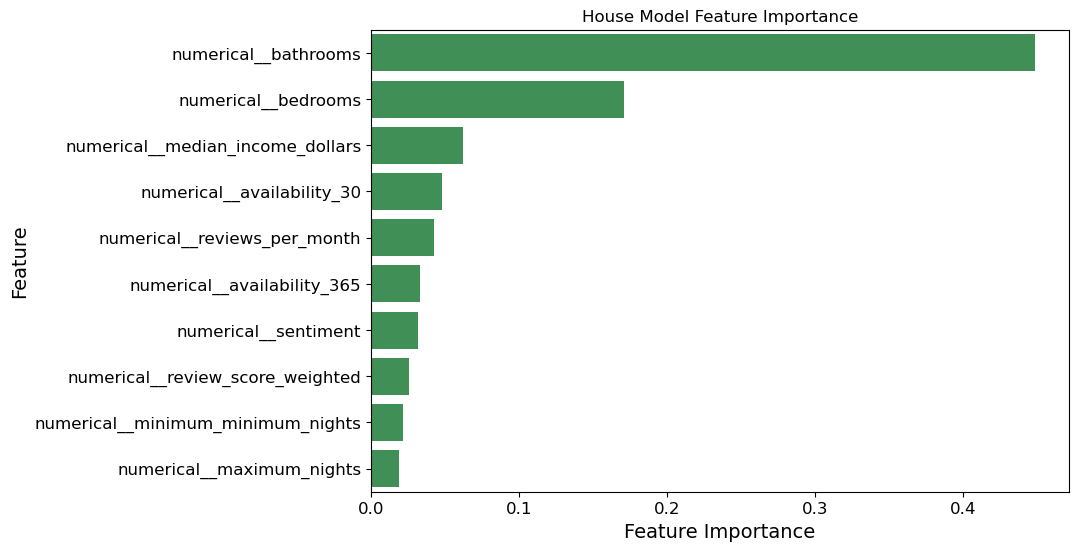

In [19]:
house_gb_load = pickle.load(open('Models/gb_house_tuned.sav', 'rb'))
feats = house_gb_load.best_estimator_.feature_names_in_.tolist()
importance = house_gb_load.best_estimator_.feature_importances_.tolist()

# Convert the features and importance scores to a dataframe
# Organize from largest to smallest importance scores
importance_df = pd.DataFrame(
    {"Feature" : feats,
     "Variable_Importance" : importance}
).sort_values(by = "Variable_Importance", ascending = False)

plt.figure(figsize=(9,6))

# Plot the top 15 features
sns.barplot(
    data = importance_df.head(10),
    x = "Variable_Importance",
    y = "Feature", 
    color=paper_green
)

plt.xlabel("Feature Importance", fontsize = 14)
plt.xticks(fontsize = 12)

plt.ylabel("Feature",fontsize = 14)
plt.yticks(fontsize = 12)
plt.title("House Model Feature Importance")


plt.show()

## Plots for the app/presentation

Note we simply changed the hex codes below to generate different colors for the app/pres

In [13]:
import matplotlib
import numpy as np
background = "#292c35"
lb = "#f6b26b"
pres_white = "#e9e2c9"
matplotlib.rc('axes', edgecolor = pres_white)

plt.rcParams["font.family"] = "Franklin Gothic Medium"
small_font = 14
medium_font = 16
big_font = 20

plt.rc('font', size= small_font)          # controls default text sizes
plt.rc('axes', titlesize= big_font)     # fontsize of the axes title
plt.rc('axes', labelsize= medium_font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_font)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_font)    # legend fontsize
plt.rc('figure', titlesize=big_font)  # fontsize of the figure title


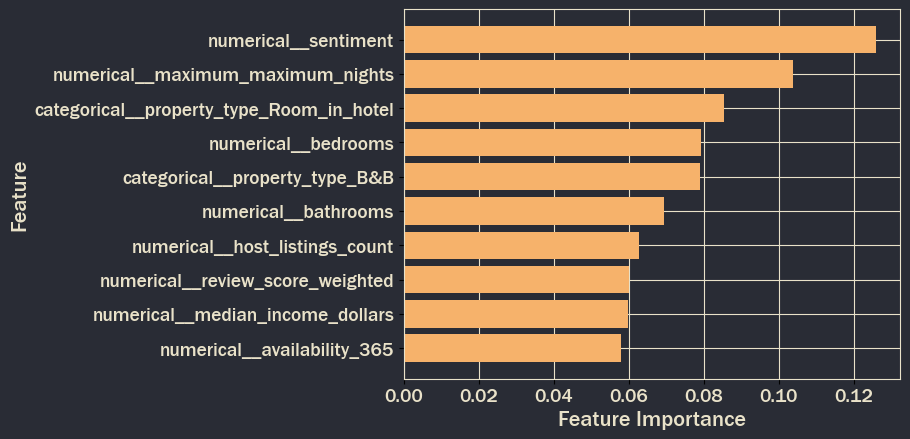

In [14]:
room_gb_load = pickle.load(open('../Models/gb_room_tuned.sav', 'rb'))# From GridSearchCV get the features and importance scores of the best model
feats = room_gb_load.best_estimator_.feature_names_in_.tolist()
feats[18] = 'categorical__property_type_B&B'
importance = room_gb_load.best_estimator_.feature_importances_.tolist()

# Convert the features and importance scores to a dataframe
# Organize from largest to smallest importance scores
importance_df = pd.DataFrame(
    {"Feature" : feats,
     "Variable_Importance" : importance}
).sort_values(by = "Variable_Importance", ascending = False)


bars = importance_df['Feature'].head(10)
height = importance_df['Variable_Importance'].head(10)
y_pos = np.arange(len(bars))
y_pos = y_pos[::-1]

fig = plt.figure(facecolor=background)
ax = plt.axes()
ax.set_facecolor(background)
ax.set_axisbelow(True)
plt.grid(color = pres_white)
plt.barh(y_pos, height, color = lb)

plt.xlabel("Feature Importance", color = pres_white)
plt.xticks(color = pres_white)

plt.ylabel("Feature", color = pres_white)
plt.yticks(y_pos, bars, color = pres_white)
#plt.title("Room Model Feature Importance", color = pres_white) # Presentation will have text boxes for plot titles

plt.show()

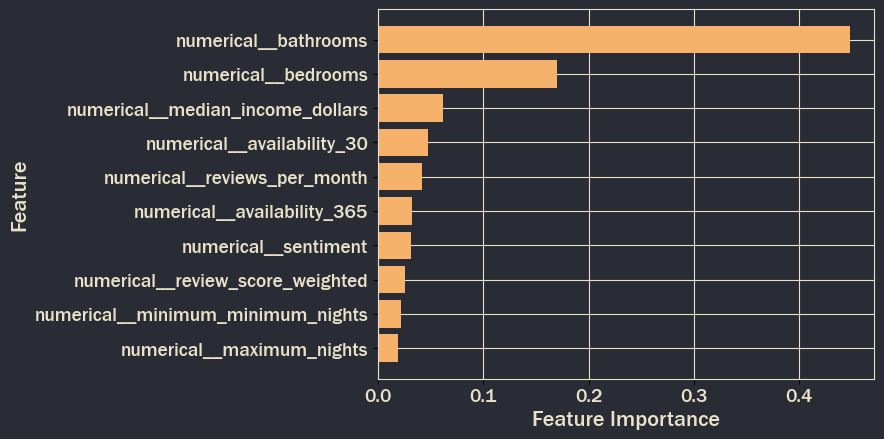

In [16]:
house_gb_load = pickle.load(open('../Models/gb_house_tuned.sav', 'rb'))
feats = house_gb_load.best_estimator_.feature_names_in_.tolist()
importance = house_gb_load.best_estimator_.feature_importances_.tolist()

# Convert the features and importance scores to a dataframe
# Organize from largest to smallest importance scores
importance_df = pd.DataFrame(
    {"Feature" : feats,
     "Variable_Importance" : importance}
).sort_values(by = "Variable_Importance", ascending = False)

bars = importance_df['Feature'].head(10)
height = importance_df['Variable_Importance'].head(10)
y_pos = np.arange(len(bars))
y_pos = y_pos[::-1]

fig = plt.figure(facecolor=background)
ax = plt.axes()
ax.set_facecolor(background)
ax.set_axisbelow(True)
plt.grid(color = pres_white)
plt.barh(y_pos, height, color = lb)

plt.xlabel("Feature Importance", color = pres_white)
plt.xticks(color = pres_white)

plt.ylabel("Feature", color = pres_white)
plt.yticks(y_pos, bars, color = pres_white)
#plt.title("House Model Feature Importance" , color = pres_white)

plt.show()

### Barcharts for pres

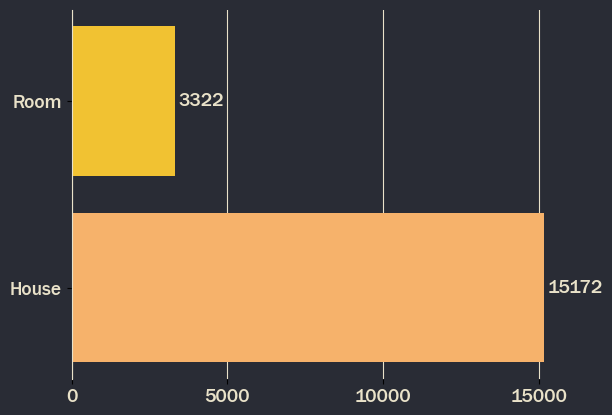

In [61]:
cat_counts = clean_data['property_type_binary'].value_counts()

# Set up plot
bars = ['House', 'Room']
height = cat_counts.values
y_pos = np.arange(len(bars))

# Bar colors
bar_color = ['#f6b26b', '#f1c232']

# Plot 
fig = plt.figure(facecolor=background)
ax = plt.axes()
ax.set_facecolor(background)
ax.set_axisbelow(True)
plt.grid(color = pres_white, axis = 'x')
plt.barh(y_pos, height, color = bar_color)

# Axis colors
plt.xlabel("", color = pres_white)
plt.xticks(np.arange(0, 15001, 5000),color = pres_white)

plt.ylabel("", color = pres_white)
plt.yticks(y_pos, bars, color = pres_white)

# Enumerate
for index, value in enumerate(cat_counts):
    plt.text(value + 100, index, str(value), color=pres_white, va='center')

# Get rid of spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

<BarContainer object of 2 artists>

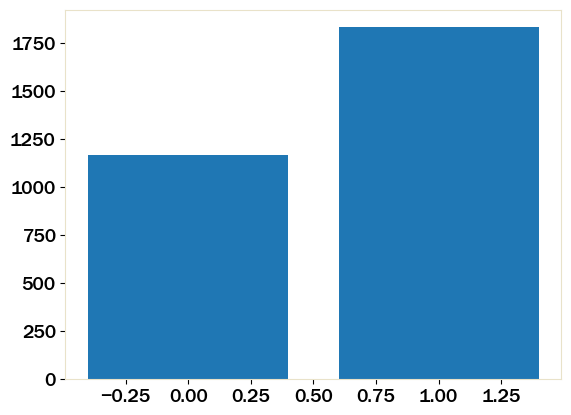

In [97]:
cat_counts = clean_data.groupby('property_type_binary')['price'].mean()

# Set up plot
bars = ['House', 'Room']
height = cat_counts.values
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)

In [127]:
clean_data.columns

Index(['host_listings_count', 'property_type', 'room_type', 'bathrooms',
       'bedrooms', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_maximum_nights', 'has_availability',
       'availability_30', 'availability_365', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'zipcode', 'median_income_dollars', 'property_type_binary', 'private',
       'sentiment', 'review_score_weighted'],
      dtype='object')

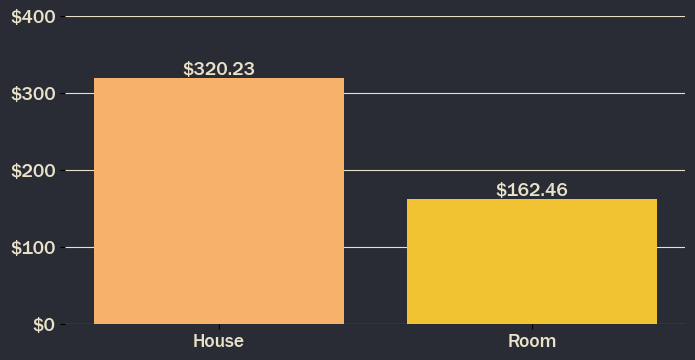

In [125]:
cat_counts = clean_data.groupby('property_type_binary')['price'].mean()

# Set up plot
bars = ['House', 'Room']
height = cat_counts.values
y_pos = range(len(bars))

# Bar colors
bar_color = ['#f6b26b', '#f1c232']

# Plot 
fig = plt.figure(facecolor=background, figsize=(8,4))
ax = plt.axes()
ax.set_facecolor(background)
ax.set_axisbelow(True)
plt.grid(color = pres_white, axis = 'y')
bar_container = plt.bar(y_pos, height, color = bar_color)

# Axis colors
plt.xlabel("", color = pres_white)
plt.xticks(y_pos, bars, color = pres_white)

plt.ylabel("", color = pres_white)
plt.yticks(np.arange(0, 500, 100),color = pres_white)

# Bar labels
ax.bar_label(bar_container, color = pres_white, fmt= '$%.2f')

# Dollar sign
ax.yaxis.set_major_formatter('${x:1.0f}')


# Get rid of spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()